### Train a U-Net on a tiny data set for segmenting roofs on aereal images

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from typing import List

from matplotlib import pyplot as plt
import skimage.io 
import numpy as np

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import albumentations as albu
import torch

### Set data directories and load data

In [2]:
DATA_DIR = './data'
IMAGES_DIR = os.path.join(DATA_DIR, 'images')
MASKS_DIR = os.path.join(DATA_DIR, 'labels')

In [3]:
train = []
test = []

for f in os.listdir(IMAGES_DIR):
    if os.path.exists(os.path.join(MASKS_DIR, f)):
        train.append(f)
    else:
        test.append(f)

In [4]:
def visualize(img_names, images_dir=IMAGES_DIR, masks_dir=MASKS_DIR, has_mask=True):
    """Plot images and masks if available."""
    n = len(img_names)
    plt.figure(figsize=(16, 5))
    for i, img_name in enumerate(img_names):
        img = skimage.io.imread(os.path.join(images_dir, img_name))
        if has_mask == True:
            mask = skimage.io.imread(os.path.join(masks_dir, img_name))
            f, axes = plt.subplots(1,2)
            axes[0].imshow(img)
            axes[0].set_title(img_name)
            axes[1].imshow(mask)
            
        else:
            plt.imshow(img)
            plt.title(img_name)
        plt.xticks([])
        plt.yticks([])
        plt.show()



<Figure size 1152x360 with 0 Axes>

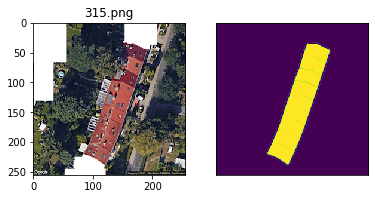

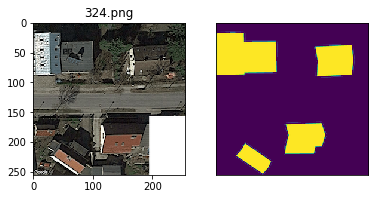

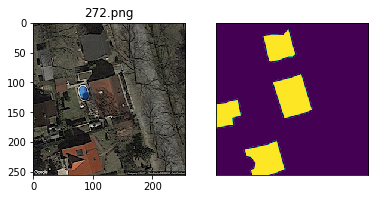

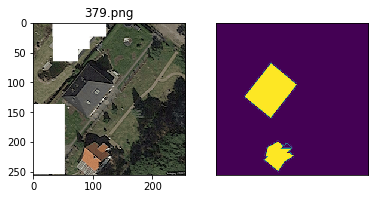

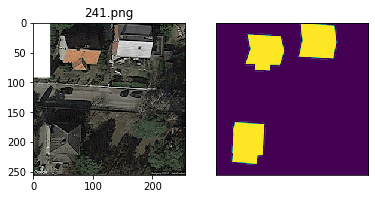

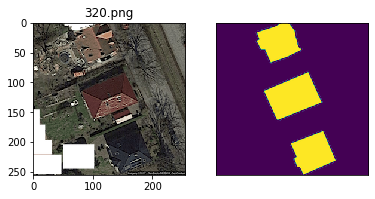

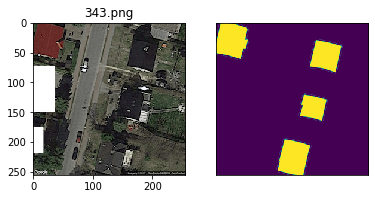

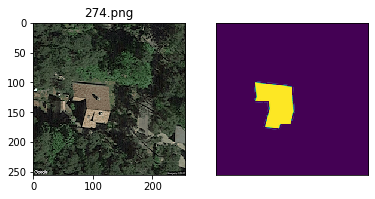

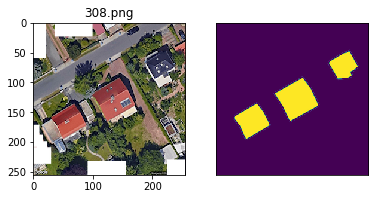

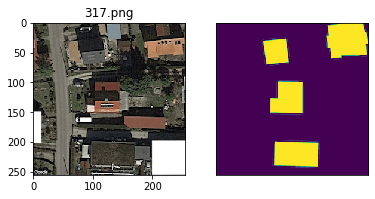

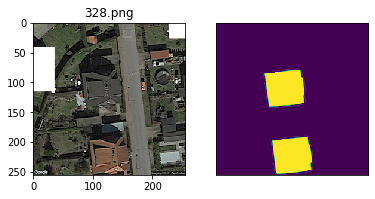

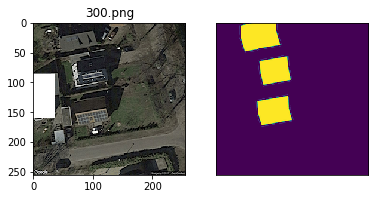

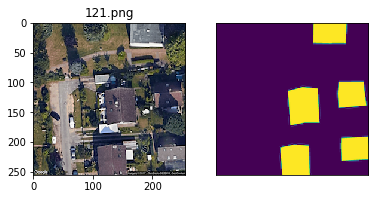

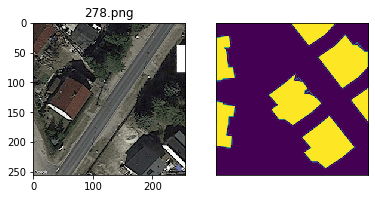

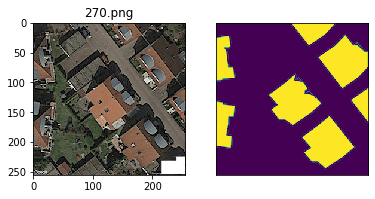

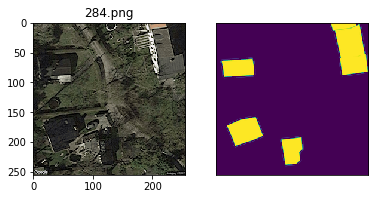

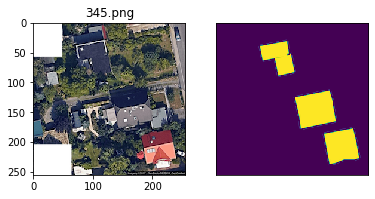

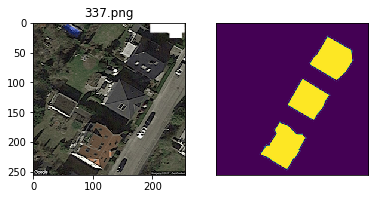

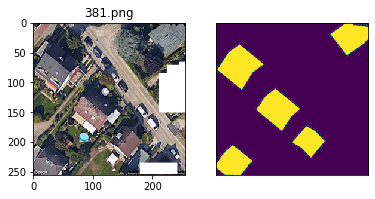

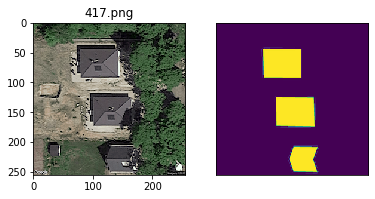

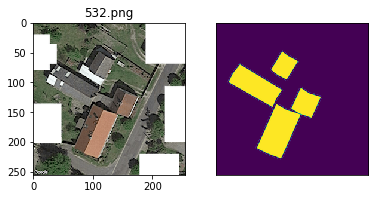

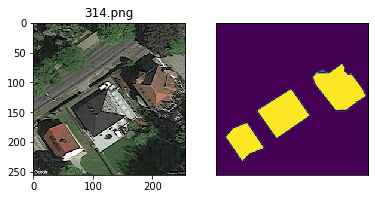

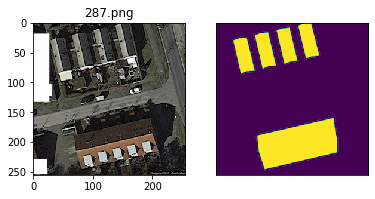

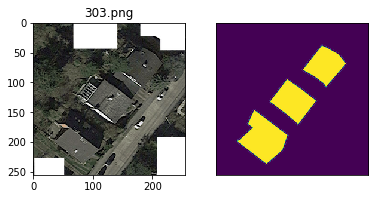

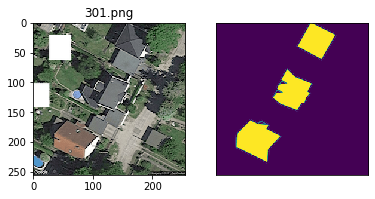

In [5]:
visualize(train)

In [6]:
len(train), len(test)

(25, 5)

In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [8]:
class Dataset(BaseDataset):
    """Tiny roof Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_names : path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['roof']
    
    def __init__(
            self, 
            img_names: List[str], 
            img_dir: str,
            mask_dir: str, 
            classes: list = None, 
            augmentation: albu.Compose = None, 
            preprocessing: albu.Compose = None,
            is_train = True
    ):
        self.img_names = img_names
        self.img_fps = [os.path.join(img_dir, img_name) for img_name in self.img_names]
        self.is_train = is_train
        if self.is_train == True:
            self.masks_fps = [os.path.join(mask_dir, img_name) for img_name in self.img_names]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = skimage.io.imread(self.img_fps[i])[:,:,0:3]
        if self.is_train == True:
            mask = skimage.io.imread(self.masks_fps[i], as_gray=True)[:,:,None]
            # apply augmentations
            if self.augmentation:
                sample = self.augmentation(image=image, mask=mask)
                image, mask = sample['image'], sample['mask']

            # apply preprocessing
            if self.preprocessing:
                sample = self.preprocessing(image=image, mask=mask)
                image, mask = sample['image'], sample['mask']
        
            return image, mask
        
        else:
            # apply preprocessing
            if self.preprocessing:
                sample = self.preprocessing(image=image)
                image = sample['image']
                
            return image, None
            
        
    def __len__(self):
        return len(self.img_names)
    
    def get_image(self, i):
        image = skimage.io.imread(self.img_fps[i])[:,:,0:3]
        return image



In [9]:
def show_img_with_mask(imgs, masks):
    """Plot images and masks if available."""
    n = len(imgs)
    plt.figure(figsize=(16, 5))
    for img, mask in zip(imgs, masks):
        if mask is not None:
            f, axes = plt.subplots(1,2)
            axes[0].imshow(img)
            axes[1].imshow(mask[:,:,0], cmap='gray')
        else:
            plt.imshow(img)
            plt.xticks([])
            plt.yticks([])
            plt.show()
    

<Figure size 1152x360 with 0 Axes>

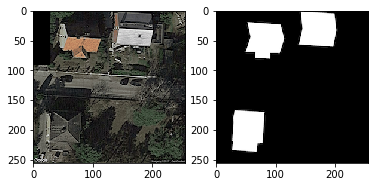

In [10]:

# Lets look at data we have

dataset = Dataset(train, IMAGES_DIR, MASKS_DIR, classes=['roof'])

image, mask = dataset[4] # get some sample
show_img_with_mask(
    imgs=[image], 
    masks=[mask],
)



In [11]:
def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.augmentations.transforms.Transpose(p=0.5),
#         albu.augmentations.transforms.Rotate(limit=90, p=0.5),
#         albu.augmentations.transforms.GridDropout(ratio = 0.5, always_apply=True),
#         albu.augmentations.transforms.MaskDropout(max_objects=1, always_apply=True),
#         albu.augmentations.functional.crop_bbox_by_coords(bbox, crop_coords, crop_height, crop_width, rows, cols)
#         albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=40, shift_limit=0.1, p=1, border_mode=0),


         albu.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
         albu.augmentations.transforms.RandomResizedCrop(256, 256, scale=(0.3, 1.0), ratio=(0.9, 1.1), interpolation=1, p=0.5),
#          albu.RandomCrop(min_max_height=(100,250), height=256, width=256, p=0.5),
#          albu.IAAAdditiveGaussianNoise(p=0.2),
#         albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(256, 256)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

/home/sascha/miniconda3/envs/py_sm/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


<Figure size 1152x360 with 0 Axes>

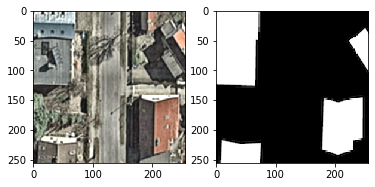

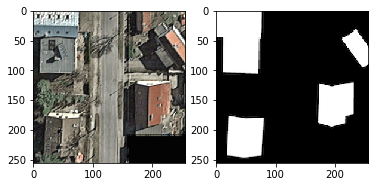

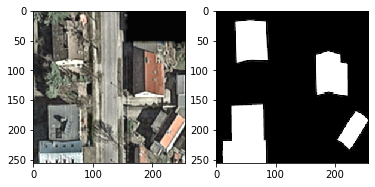

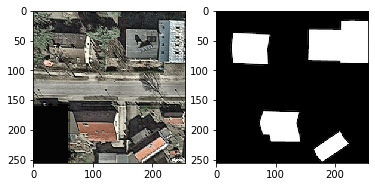

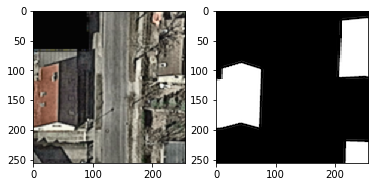

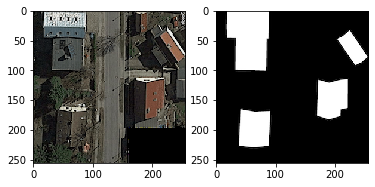

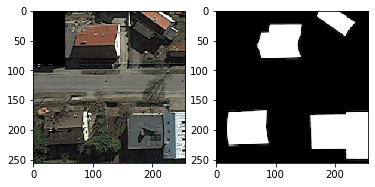

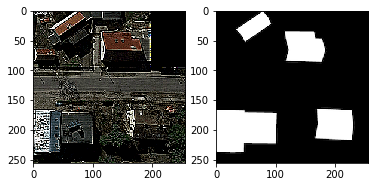

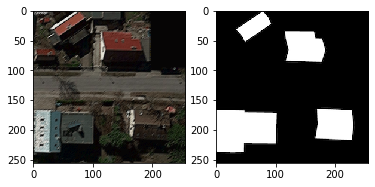

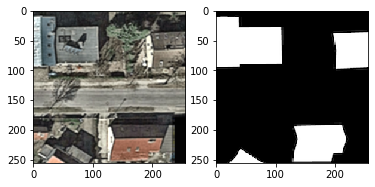

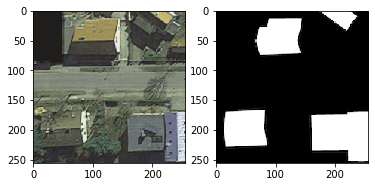

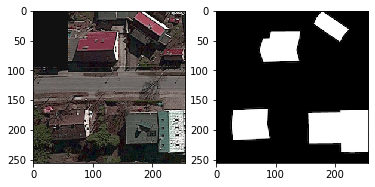

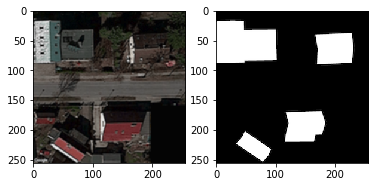

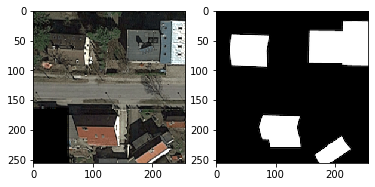

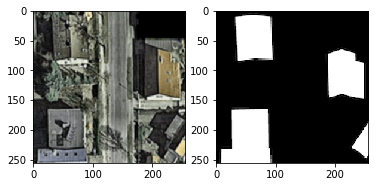

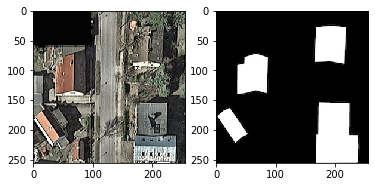

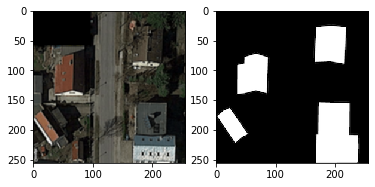

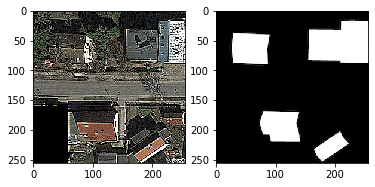

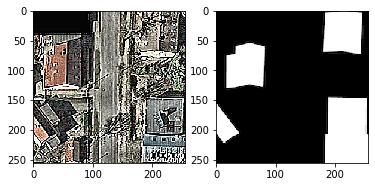

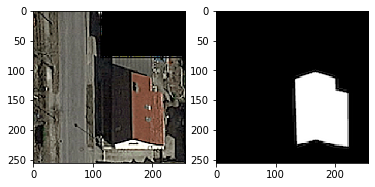

In [12]:


#### Visualize resulted augmented images and masks
augmented_dataset = Dataset(train, IMAGES_DIR, MASKS_DIR, classes=['roof'], augmentation=get_training_augmentation())

# augmented_dataset = Dataset(
#     x_train_dir, 
#     y_train_dir, 
#     augmentation=get_training_augmentation(), 
#     classes=['car'],
# )

# same image with different random transforms
imgs, masks = [], []
for i in range(20):
    image, mask = augmented_dataset[1]
    imgs.append(image), masks.append(mask)
    
show_img_with_mask(imgs=imgs, masks=masks)



In [13]:
ENCODER = 'resnet18' #'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['roof']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [14]:
train_dataset =  Dataset(train[:20], IMAGES_DIR, MASKS_DIR, augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn), classes=['roof'])


valid_dataset =  Dataset(train[20:], IMAGES_DIR, MASKS_DIR, augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn), classes=['roof'])
                                                                


train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=1)

In [15]:

loss = smp.utils.losses.BCELoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [16]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [17]:
# train model

epochs = 200
max_score = 0

for i in range(0, 200):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 5/5 [00:00<00:00, 32.70it/s, bce_loss - -82.7, iou_score - 28.84] 
Model saved!

Epoch: 1
valid: 100%|██████████| 5/5 [00:00<00:00, 34.44it/s, bce_loss - -197.2, iou_score - 31.92]
Model saved!

Epoch: 2
valid: 100%|██████████| 5/5 [00:00<00:00, 32.65it/s, bce_loss - -144.0, iou_score - 28.81]

Epoch: 3
valid: 100%|██████████| 5/5 [00:00<00:00, 29.32it/s, bce_loss - -126.7, iou_score - 28.17]

Epoch: 4
valid: 100%|██████████| 5/5 [00:00<00:00, 33.14it/s, bce_loss - -102.1, iou_score - 23.94]

Epoch: 5
valid: 100%|██████████| 5/5 [00:00<00:00, 29.11it/s, bce_loss - -112.2, iou_score - 37.68]
Model saved!

Epoch: 6
valid: 100%|██████████| 5/5 [00:00<00:00, 32.71it/s, bce_loss - -102.2, iou_score - 29.89]

Epoch: 7
valid: 100%|██████████| 5/5 [00:00<00:00, 30.70it/s, bce_loss - -133.5, iou_score - 34.48]

Epoch: 8
valid: 100%|██████████| 5/5 [00:00<00:00, 34.41it/s, bce_loss - -205.2, iou_score - 39.31]
Model saved!

Epoch: 9
valid: 100%|██████████| 5/5 [

valid: 100%|██████████| 5/5 [00:00<00:00, 30.18it/s, bce_loss - -320.5, iou_score - 12.11]

Epoch: 42
valid: 100%|██████████| 5/5 [00:00<00:00, 32.38it/s, bce_loss - -313.3, iou_score - 12.82]

Epoch: 43
valid: 100%|██████████| 5/5 [00:00<00:00, 29.64it/s, bce_loss - -306.6, iou_score - 11.15]

Epoch: 44
valid: 100%|██████████| 5/5 [00:00<00:00, 29.28it/s, bce_loss - -311.3, iou_score - 11.33]

Epoch: 45
valid: 100%|██████████| 5/5 [00:00<00:00, 31.17it/s, bce_loss - -297.1, iou_score - 10.92]

Epoch: 46
valid: 100%|██████████| 5/5 [00:00<00:00, 31.87it/s, bce_loss - -309.5, iou_score - 12.27]

Epoch: 47
valid: 100%|██████████| 5/5 [00:00<00:00, 31.00it/s, bce_loss - -302.4, iou_score - 10.32]

Epoch: 48
valid: 100%|██████████| 5/5 [00:00<00:00, 28.43it/s, bce_loss - -305.2, iou_score - 10.36]

Epoch: 49
valid: 100%|██████████| 5/5 [00:00<00:00, 32.70it/s, bce_loss - -334.7, iou_score - 15.6] 

Epoch: 50
valid: 100%|██████████| 5/5 [00:00<00:00, 32.43it/s, bce_loss - -315.5, iou_score 

valid: 100%|██████████| 5/5 [00:00<00:00, 30.15it/s, bce_loss - -338.8, iou_score - 12.16]

Epoch: 84
valid: 100%|██████████| 5/5 [00:00<00:00, 31.30it/s, bce_loss - -339.8, iou_score - 11.62]

Epoch: 85
valid: 100%|██████████| 5/5 [00:00<00:00, 31.66it/s, bce_loss - -321.6, iou_score - 10.2] 

Epoch: 86
valid: 100%|██████████| 5/5 [00:00<00:00, 30.89it/s, bce_loss - -338.6, iou_score - 12.65]

Epoch: 87
valid: 100%|██████████| 5/5 [00:00<00:00, 31.69it/s, bce_loss - -320.2, iou_score - 10.22]

Epoch: 88
valid: 100%|██████████| 5/5 [00:00<00:00, 31.48it/s, bce_loss - -304.2, iou_score - 10.14]

Epoch: 89
valid: 100%|██████████| 5/5 [00:00<00:00, 32.42it/s, bce_loss - -328.9, iou_score - 11.48]

Epoch: 90
valid: 100%|██████████| 5/5 [00:00<00:00, 27.83it/s, bce_loss - -315.5, iou_score - 9.602]

Epoch: 91
valid: 100%|██████████| 5/5 [00:00<00:00, 30.80it/s, bce_loss - -332.8, iou_score - 11.04]

Epoch: 92
valid: 100%|██████████| 5/5 [00:00<00:00, 33.41it/s, bce_loss - -316.6, iou_score 

valid: 100%|██████████| 5/5 [00:00<00:00, 29.06it/s, bce_loss - -359.2, iou_score - 10.89]

Epoch: 126
valid: 100%|██████████| 5/5 [00:00<00:00, 31.55it/s, bce_loss - -369.6, iou_score - 12.1] 

Epoch: 127
valid: 100%|██████████| 5/5 [00:00<00:00, 30.48it/s, bce_loss - -362.6, iou_score - 11.13]

Epoch: 128
valid: 100%|██████████| 5/5 [00:00<00:00, 31.35it/s, bce_loss - -354.3, iou_score - 9.882]

Epoch: 129
valid: 100%|██████████| 5/5 [00:00<00:00, 31.68it/s, bce_loss - -355.7, iou_score - 10.96]

Epoch: 130
valid: 100%|██████████| 5/5 [00:00<00:00, 31.87it/s, bce_loss - -327.8, iou_score - 9.318]

Epoch: 131
valid: 100%|██████████| 5/5 [00:00<00:00, 19.83it/s, bce_loss - -297.5, iou_score - 8.193]

Epoch: 132
valid: 100%|██████████| 5/5 [00:00<00:00, 31.39it/s, bce_loss - -329.2, iou_score - 9.167]

Epoch: 133
valid: 100%|██████████| 5/5 [00:00<00:00, 30.03it/s, bce_loss - -328.0, iou_score - 8.533]

Epoch: 134
valid: 100%|██████████| 5/5 [00:00<00:00, 24.71it/s, bce_loss - -362.3, i

valid: 100%|██████████| 5/5 [00:00<00:00, 26.43it/s, bce_loss - -421.3, iou_score - 13.51]

Epoch: 167
valid: 100%|██████████| 5/5 [00:00<00:00, 30.87it/s, bce_loss - -362.5, iou_score - 9.197]

Epoch: 168
valid: 100%|██████████| 5/5 [00:00<00:00, 29.05it/s, bce_loss - -327.6, iou_score - 6.86]

Epoch: 169
valid: 100%|██████████| 5/5 [00:00<00:00, 29.08it/s, bce_loss - -437.2, iou_score - 10.7] 

Epoch: 170
valid: 100%|██████████| 5/5 [00:00<00:00, 33.07it/s, bce_loss - -402.4, iou_score - 11.45]

Epoch: 171
valid: 100%|██████████| 5/5 [00:00<00:00, 28.38it/s, bce_loss - -387.1, iou_score - 9.12] 

Epoch: 172
valid: 100%|██████████| 5/5 [00:00<00:00, 28.94it/s, bce_loss - -368.3, iou_score - 9.533]

Epoch: 173
valid: 100%|██████████| 5/5 [00:00<00:00, 30.41it/s, bce_loss - -350.2, iou_score - 8.091]

Epoch: 174
valid: 100%|██████████| 5/5 [00:00<00:00, 28.02it/s, bce_loss - -399.8, iou_score - 11.83]

Epoch: 175
valid: 100%|██████████| 5/5 [00:00<00:00, 28.48it/s, bce_loss - -384.6, io

### Load best model and predict on test data

In [18]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

# test dataset without transformations for image visualization
test_dataset = Dataset(test, IMAGES_DIR, MASKS_DIR, 
    preprocessing=get_preprocessing(preprocessing_fn), classes=['roof'], is_train=False)


<Figure size 1152x360 with 0 Axes>

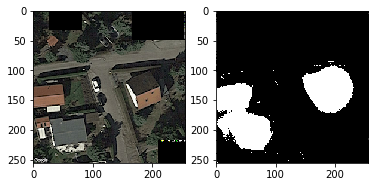

<Figure size 1152x360 with 0 Axes>

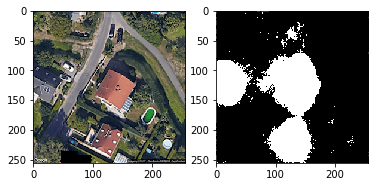

<Figure size 1152x360 with 0 Axes>

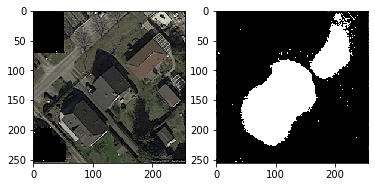

<Figure size 1152x360 with 0 Axes>

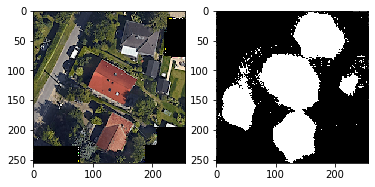

<Figure size 1152x360 with 0 Axes>

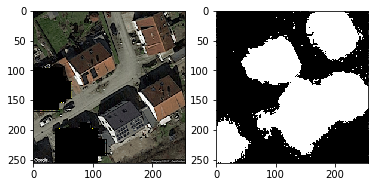

In [19]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset.get_image(n)
    image, mask =  test_dataset[n]
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    show_img_with_mask([image_vis], [pr_mask[:,:,None]])


